<a href="https://colab.research.google.com/github/arminwitte/mistral-peft/blob/main/unsloth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Domain Adaptation using QLoRA

This notebook is set to demonstrate the fine-tuning of the language model mistral 7b to data from my dissertation

[Witte, A. (2018). Dynamics of unsteady heat transfer and skin friction in pulsating flow across a cylinder (Doctoral dissertation, Technische Universität München).](https://mediatum.ub.tum.de/doc/1436573/document.pdf)

Training is achieved in two parts. In part 1 the LoRA is pre-trained with self-supervised training (CLM). Afterwards, in part 2, the adapter is fine-tuned for instructions using supervised training.

**Notes:**
- Data preparation is very rudimentary and might impair the quality of the response.
- Instruction data for supervised training was crated using [alpacarizer](https://github.com/arminwitte/alpacarizer)
- The notebook is set to run in Google Colab on a T4 GPU

In [ ]:
# Clone the git repo to access the utilities
!git clone https://github.com/arminwitte/mistral-peft mistralpeft

Cloning into 'mistralpeft'...
remote: Enumerating objects: 222, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 222 (delta 15), reused 24 (delta 5), pack-reused 183 (from 3)
Receiving objects: 100% (222/222), 641.67 MiB | 15.57 MiB/s, done.
Resolving deltas: 100% (109/109), done.


In [ ]:
# Make sure to be on the repo directory and hard reset to the latest commit
import os
from pathlib import Path

git_path = Path("/content/mistralpeft")
if not os.getcwd() == git_path:
    os.chdir(git_path)
!pwd
!git fetch --all
!git reset --hard origin/main

/content/mistralpeft
Fetching origin
HEAD is now at d29693e black


In [ ]:
# Access Google Drive to permanently save e.g. checkpoints
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Set the path to the LoRA weights
path_to_lora_weights = Path("/content/drive/MyDrive/mistral-peft/lora_weights")

In [ ]:
# Install the required packages from pypi or github

# https://github.com/unslothai/unsloth/issues/1181#issuecomment-2439923851
!pip install pip3-autoremove
!pip-autoremove torch torchvision torchaudio fastai -y
!pip install torch torchvision torchaudio xformers --index-url https://download.pytorch.org/whl/cu124
!pip install --no-deps "tyro>=0.5.11"
!pip install --no-deps "trl<0.9.0" peft accelerate bitsandbytes

!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git@2025-02-v2"

!pip install -r requirements.txt

The 'jedi>=0.16' distribution was not found and is required by the application
Skipping jedi
nvidia-cuda-nvrtc-cu12 12.5.82 is installed but nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64" is required
Redoing requirement with just package name...
nvidia-cuda-runtime-cu12 12.5.82 is installed but nvidia-cuda-runtime-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64" is required
Redoing requirement with just package name...
nvidia-cuda-cupti-cu12 12.5.82 is installed but nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64" is required
Redoing requirement with just package name...
nvidia-cudnn-cu12 9.3.0.75 is installed but nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64" is required
Redoing requirement with just package name...
nvidia-cublas-cu12 12.5.3.2 is installed but nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.8/385.8 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.9 MB/s eta 0:00:00
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 6.1.12
    Uninstalling jupyter-client-6.1.12:
      Successfully uninstalled jupyter-client-6.1.12
  Attempting uninstall: jupyter-server
    Found existing installation: jupyter-server 1.24.0
    Uninstalling jupyter-server-1.24.0:
      Successfully uninstalled jupyter-server-

In [ ]:
# Load packages
import unsloth

import json
import gc
import glob

from transformers import Trainer, TrainingArguments
from huggingface_hub import login
from peft import PeftModel
from datasets import Dataset
from google.colab import userdata
from unsloth import FastLanguageModel
import torch
import matplotlib.pyplot as plt
from trl import SFTTrainer

from mistralpeft.utils import TextExtractor, CLMPreprocessor

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [ ]:
# Login to HuggingFace using Colab's secrets to be able to download models
login(userdata.get("HF_TOKEN"))

## Part 1: Self-supervised pretraining

### 1. Extract and transform text from dissertation (PDF)

In [ ]:
# TextExtractor is a simple ET(L) class to acquire a text corpus
pdf_files = [
    "Dissertation.pdf",
]

pdf_urls = [
    "https://mediatum.ub.tum.de/doc/1360567/1360567.pdf",
    "https://mediatum.ub.tum.de/doc/1601190/1601190.pdf",
    "https://mediatum.ub.tum.de/doc/1597610/1597610.pdf"
    "https://mediatum.ub.tum.de/doc/1584750/1584750.pdf",
    "https://mediatum.ub.tum.de/doc/1484812/1484812.pdf",
    "https://mediatum.ub.tum.de/doc/1335646/1335646.pdf",
    "https://mediatum.ub.tum.de/doc/1326486/1326486.pdf",
    "https://mediatum.ub.tum.de/doc/1306410/1306410.pdf",
    "https://mediatum.ub.tum.de/doc/1444929/1444929.pdf",
]

data_path = Path("data/processed_documents.json")
if True:  # not data_path.is_file():
    with TextExtractor("data/processed_documents.json") as extractor:
        # Process local files
        extractor.process_documents(pdf_files)

        # Process URLs
        # extractor.process_documents(pdf_urls, url_list=True)
        pass

Processing documents: 100%|██████████| 1/1 [00:17<00:00, 17.77s/it]


### 2. Load and Prepare Model

In [ ]:
# Load model and tokenizer from unsloth
max_seq_length = 2 * 2 * 2048  # Choose any! We auto support RoPE Scaling internally!
dtype = (
    torch.float16
)  # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True  # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/mistral-7b-bnb-4bit",  # Choose ANY! eg teknium/OpenHermes-2.5-Mistral-7B
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
)

==((====))==  Unsloth 2025.2.14: Fast Mistral patching. Transformers: 4.48.3.
   \\   /|    GPU: Tesla T4. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/4.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/155 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

In [ ]:
# Set the LoRA
peft_model = FastLanguageModel.get_peft_model(
    model,
    r=16,  # rank
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],
    lora_alpha=16,
    lora_dropout=0,  # 0 is optimized
    bias="none",  # "none" is optimized
    use_gradient_checkpointing="unsloth",
    random_state=4711,
    use_rslora=False,  # rank stabilized LoRA
    loftq_config=None,  # LoftQ
)

Unsloth 2025.2.14 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


### 3. Prepare CLM Training Data

In [ ]:
# Preprocess the corpus for Causal Language Modeling (CLM)
json_file_paths = ["data/processed_documents.json"]
preprocessor = CLMPreprocessor(json_file_paths, tokenizer)
dataset = preprocessor.preprocess()

In [ ]:
# Split into training and test set
train_test_set = dataset.train_test_split(test_size=0.1)
print(
    f"Created {len(train_test_set['train'])} training examples and {len(train_test_set['test'])} test examples"
)

# Preview a training example
example = train_test_set["train"][0]
print("Example input:")
print(preprocessor.tokenizer.decode(example["input_ids"][:256]))

Created 39 training examples and 5 test examples
Example input:
values for CTA (Bruun, 1996). The natural frequency can be brought into the dimensionless framework by Sr = f 2πd 2 Re 0 ν. (9.021) Figure 9.07 shows the amplitude of the frequency responses in a Bode diagram in a log–log plot. This format was chosen to display a wide range of frequencies. The values were assessed for a wire probe made of platinum and air at ambient condi- tions. The mean flow Reynolds number is Re 0 = 40. The cutoff Strouhal number of the CTA controller depends on the wire diameter and was evaluated for d = 5µm. Thicker wires would only affect the graph of the CTA and place the cutoff frequency further to the right. Heat conduction and storage in the solid wire are comparatively slow processes which can be seen by the low cutoff Strouhal number of the wire itself. Both the response to velocity magnitude fluctuations and fluctuations in the angle of attack can be considered quasi-stationary in this frequen

In [ ]:
# Show a sequence from the tokenized input and labels.
# For CLM the labels should be shifted to the left by 1.
print(train_test_set["train"]["input_ids"][0][16:33])
print(train_test_set["train"]["labels"][0][16:33])

[4229, 11010, 541, 347, 4248, 778, 272, 9711, 1503, 10782, 486, 25854, 327, 285, 28705, 28750, 29030]
[11010, 541, 347, 4248, 778, 272, 9711, 1503, 10782, 486, 25854, 327, 285, 28705, 28750, 29030, 28715]


### 4. Train the Model

In [ ]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/mistral-peft/results/2025-03-12",
    num_train_epochs=4,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=3,  # Creates a virtual batch size of 3
    learning_rate=3e-4,
    fp16=True,  # numerical precision of adapter is float16
    logging_steps=1,
    eval_strategy="steps",
    eval_steps=10,
    save_strategy="steps",
    save_steps=10,
    load_best_model_at_end=True,
    optim="paged_adamw_8bit",  # Memory efficient optimizer
    log_level="info",
    report_to="none",
)

# Initialize trainer
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_test_set["train"],
    eval_dataset=train_test_set["test"],
)

Using auto half precision backend


In [ ]:
# Start training
trainer.train(
    resume_from_checkpoint=False
)  # "/content/drive/MyDrive/mistral-peft/results/2025-02-26/checkpoint-264")

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 39 | Num Epochs = 4
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 3
\        /    Total batch size = 3 | Total steps = 52
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
10,4.368200,4.238827
20,2.927700,3.519614
30,2.458100,3.247856



***** Running Evaluation *****
  Num examples = 5
  Batch size = 1
Unsloth: Not an error, but MistralForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient
Saving model checkpoint to /content/drive/MyDrive/mistral-peft/results/2025-03-12/checkpoint-10
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--unsloth--mistral-7b-bnb-4bit/snapshots/3c47be0aa392c058e26ede776ecd2d5416fa5d28/config.json
Model config MistralConfig {
  "_name_or_path": "unsloth/mistral-7b",
  "architectures": [
    "MistralForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 32768,
  "model_type": "mistral",
  "num_attention_heads": 32,
  "num_hidden_la

Step,Training Loss,Validation Loss
10,4.368200,4.238827
20,2.927700,3.519614
30,2.458100,3.247856
40,1.938600,3.126432
50,2.094200,3.084941



***** Running Evaluation *****
  Num examples = 5
  Batch size = 1
Saving model checkpoint to /content/drive/MyDrive/mistral-peft/results/2025-03-12/checkpoint-40
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--unsloth--mistral-7b-bnb-4bit/snapshots/3c47be0aa392c058e26ede776ecd2d5416fa5d28/config.json
Model config MistralConfig {
  "_name_or_path": "unsloth/mistral-7b",
  "architectures": [
    "MistralForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 32768,
  "model_type": "mistral",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pad_token_id": 0,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_storage": "uint8",
    "bn

TrainOutput(global_step=52, training_loss=3.910518664580125, metrics={'train_runtime': 2132.0502, 'train_samples_per_second': 0.073, 'train_steps_per_second': 0.024, 'total_flos': 2.7422050448572416e+16, 'train_loss': 3.910518664580125, 'epoch': 4.0})

In [ ]:
# Save the LoRA adapter weights
peft_model.save_pretrained(path_to_lora_weights)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--unsloth--mistral-7b-bnb-4bit/snapshots/3c47be0aa392c058e26ede776ecd2d5416fa5d28/config.json
Model config MistralConfig {
  "_name_or_path": "unsloth/mistral-7b",
  "architectures": [
    "MistralForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 32768,
  "model_type": "mistral",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pad_token_id": 0,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_storage": "uint8",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int

dict_keys(['best_metric', 'best_model_checkpoint', 'epoch', 'eval_steps', 'global_step', 'is_hyper_param_search', 'is_local_process_zero', 'is_world_process_zero', 'log_history', 'logging_steps', 'max_steps', 'num_input_tokens_seen', 'num_train_epochs', 'save_steps', 'stateful_callbacks', 'total_flos', 'train_batch_size', 'trial_name', 'trial_params'])


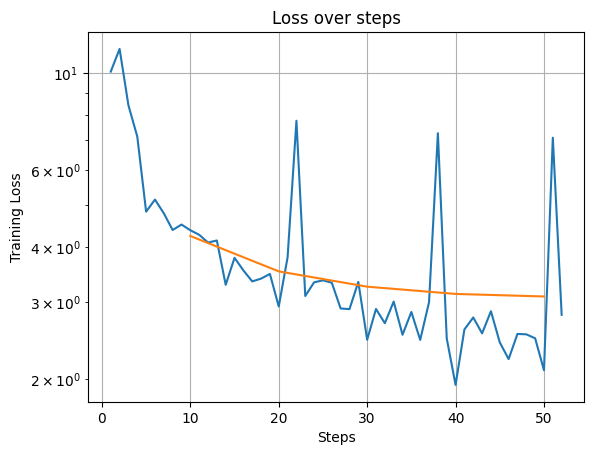

In [ ]:
# Plot the training loss
paths = glob.glob("/content/drive/MyDrive/mistral-peft/results/2025-03-12/checkpoint-*")
train_info_path = Path(sorted(paths)[-1]) / "trainer_state.json"
with open(train_info_path, "r") as f:
    train_info = json.load(f)

print(train_info.keys())
train_steps = [int(d["step"]) for d in train_info["log_history"] if "loss" in d]
train_loss = [float(d["loss"]) for d in train_info["log_history"] if "loss" in d]
eval_steps = [int(d["step"]) for d in train_info["log_history"] if "eval_loss" in d]
eval_loss = [
    float(d["eval_loss"]) for d in train_info["log_history"] if "eval_loss" in d
]
fig, ax = plt.subplots()
ax.plot(train_steps, train_loss)
ax.plot(eval_steps, eval_loss)
ax.set_xlabel("Steps")
ax.set_ylabel("Training Loss")
ax.set_yscale('log')
ax.grid(True)
ax.title.set_text("Loss over steps")
plt.show()

### 5. Test the Model

In [ ]:
def test_continuation(model_token_list):  # Example queries

    for model, tokenizer in model_token_list:
        # model.generation_config.pad_token_id = tokenizer.pad_token_id
        FastLanguageModel.for_inference(model)

    orig = [
        "SI is used when processes are either too complex to gain insight using first principles, i.e. physical laws, or the calculation is too costly in terms of time or resources. Its goal is to obtain an efficient and accurate model for a process from acquired data. The properties of this model can be analyzed to get insight in the process, or the model may be used for further calculations.",
        "In pulsating or oscillating flow, heat transfer can damp, but also drive instabilities. The first observations of this thermoacoustic effect caused by heat transfer were reported by Sondhauß and Rijke.",
        "the unit step response gives the cumulated contribution at each instant in time. The step response is the output acquired in answer to a Heaviside step function",
    ]

    queries = [
        "SI is used when processes are either too complex to gain insight using first principles, i.e. physical laws, or the calculation is too costly in terms of time or resources. Its goal is to",
        "In pulsating or oscillating flow, heat transfer can damp, but also",
        "the unit step response gives the cumulated contribution at",
    ]

    # Generate responses
    for i, query in enumerate(queries):

        print(f"\nOriginal:\t\t {orig[i]}")
        print(f"\nQuery:\t\t\t {query}")
        j = 0
        for model, tokenizer in model_token_list:
            inputs = tokenizer(query, return_tensors="pt").to("cuda")
            outputs = model.generate(
                input_ids=inputs.input_ids,
                attention_mask=inputs.attention_mask,
                max_new_tokens=50,
                num_return_sequences=1,
                temperature=0.3,  # Using Ollama's likely default
                top_p=0.9,
                top_k=10,
                repetition_penalty=1.2,
                do_sample=True,
            )
            text = tokenizer.decode(outputs[0], skip_special_tokens=True)
            print(f"\nResponse model {j}:\t {text}")
            j += 1
        print("-" * 80)

In [ ]:
# Run the test in the original model and the fine-tuned model
test_continuation([(model, tokenizer), (peft_model, tokenizer)])


Original:		 SI is used when processes are either too complex to gain insight using first principles, i.e. physical laws, or the calculation is too costly in terms of time or resources. Its goal is to obtain an efficient and accurate model for a process from acquired data. The properties of this model can be analyzed to get insight in the process, or the model may be used for further calculations.

Query:			 SI is used when processes are either too complex to gain insight using first principles, i.e. physical laws, or the calculation is too costly in terms of time or resources. Its goal is to

Response model 0:	 SI is used when processes are either too complex to gain insight using first principles, i.e. physical laws, or the calculation is too costly in terms of time or resources. Its goal is to a model system with characteristics similar the one interest and use this as representation The process be described by mathematical ( usually equations which solved numer). can also applied s

## Part 2: Supervised instruction finetuning

In [ ]:
# clean up
del model, peft_model, tokenizer
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()

### 1. Load and prepare model

In [ ]:
# Get the quantized instruct model and the corresponding tokenizer
instruct_model, instruct_tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
)

In [ ]:
# Prepare the instruct model with the adapter
instruct_model.enable_input_require_grads()
peft_model = PeftModel.from_pretrained(
    instruct_model, path_to_lora_weights, is_trainable=True
)
peft_model._mark_only_adapters_as_trainable(peft_model)

### 2. Prepare instruction data

In [ ]:
# load data from json file
with open("data/instruction_data.json", "r") as f:
    instruction_data = json.load(f)

# Create a dataset from the list
dataset = Dataset.from_list(instruction_data)

In [ ]:
# Format the dataset in alpaca-style
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""


def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs = examples["input"]
    outputs = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        text = alpaca_prompt.format(instruction, input, output)
        texts.append(text)
    return {
        "text": texts,
    }


pass

dataset = dataset.map(
    formatting_prompts_func,
    batched=True,
)

Map:   0%|          | 0/915 [00:00<?, ? examples/s]

In [ ]:
# Split into training and test set
train_test_set = dataset.train_test_split(test_size=0.1)
print(
    f"Created {len(train_test_set['train'])} training examples and {len(train_test_set['test'])} test examples"
)

### 3. Fine-tuning of the adapter

In [ ]:
# Set the training arguments for supervised training
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/mistral-peft/results/2025-03-12/instruct/",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    warmup_steps=5,
    num_train_epochs=4,
    learning_rate=2e-4,
    weight_decay=0.01,
    fp16=True,
    bf16=False,
    save_steps=100,
    logging_steps=100,
    eval_steps=100,
    optim="paged_adamw_8bit",
    lr_scheduler_type="linear",
    seed=815,
    report_to="none",
    log_level="warning",
)

# Initialize the trainer
trainer = SFTTrainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_test_set["train"],
    eval_dataset=train_test_set["test"],
    tokenizer=instruct_tokenizer,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    packing=False,  # Can make training 5x faster for short sequences.
    formatting_func=formatting_prompts_func,
)

In [ ]:
# Execute training
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 823 | Num Epochs = 4
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 4
\        /    Total batch size = 4 | Total steps = 820
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
100,1.223200
200,0.820000
300,0.434000
400,0.407800
500,0.205800


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetunin

Step,Training Loss
100,1.223200
200,0.820000
300,0.434000
400,0.407800
500,0.205800
600,0.179300
700,0.095100
800,0.073700


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


TrainOutput(global_step=820, training_loss=0.4217412233352661, metrics={'train_runtime': 3033.4132, 'train_samples_per_second': 1.085, 'train_steps_per_second': 0.27, 'total_flos': 3.4467210045210624e+16, 'train_loss': 0.4217412233352661, 'epoch': 3.9817739975698663})

In [ ]:
# save the trained adapter
peft_model.save_pretrained(
    Path(path_to_lora_weights, "instruct"), save_embedding_layers=True
)

dict_keys(['best_metric', 'best_model_checkpoint', 'epoch', 'eval_steps', 'global_step', 'is_hyper_param_search', 'is_local_process_zero', 'is_world_process_zero', 'log_history', 'logging_steps', 'max_steps', 'num_input_tokens_seen', 'num_train_epochs', 'save_steps', 'stateful_callbacks', 'total_flos', 'train_batch_size', 'trial_name', 'trial_params'])


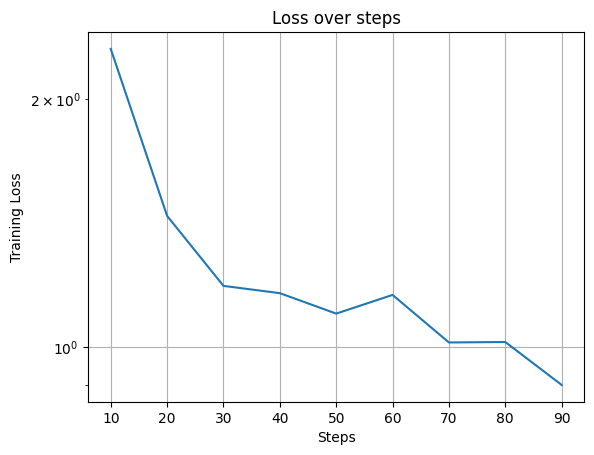

In [ ]:
# Plot the training loss
paths = glob.glob(
    "/content/drive/MyDrive/mistral-peft/results/2025-03-12/instruct/checkpoint-*"
)
train_info_path = Path(sorted(paths)[-1]) / "trainer_state.json"
with open(train_info_path, "r") as f:
    train_info = json.load(f)

print(train_info.keys())
train_steps = [int(d["step"]) for d in train_info["log_history"] if "loss" in d]
train_loss = [float(d["loss"]) for d in train_info["log_history"] if "loss" in d]
eval_steps = [int(d["step"]) for d in train_info["log_history"] if "eval_loss" in d]
eval_loss = [
    float(d["eval_loss"]) for d in train_info["log_history"] if "eval_loss" in d
]
fig, ax = plt.subplots()
ax.plot(train_steps, train_loss)
ax.plot(eval_steps, eval_loss)
ax.set_xlabel("Steps")
ax.set_ylabel("Training Loss")
ax.grid(True)
ax.set_yscale('log')
ax.title.set_text("Loss over steps")
plt.show()

### 4. Test the fine-tuned instruction model

In [ ]:
def test_instruct(model_token_list):
    for model, tokenizer in model_token_list:
        # model.generation_config.pad_token_id = tokenizer.pad_token_id
        FastLanguageModel.for_inference(model)

    questions = [
        "Explain System Identification",
        "How is heat transfer influenced by pulsating or oscillating flow?",
        "What is a unit step response?",
    ]

    for i, question in enumerate(questions):
        print(f"\nQuestion:\t\t\t {question}")
        j = 0
        for model, tokenizer in model_token_list:
            message = [{"role": "user", "content": question}]

            instruct_tokenizer.pad_token_id = instruct_tokenizer.eos_token_id
            formatted_prompt = instruct_tokenizer.apply_chat_template(
                message, return_tensors="pt", tokenize=False
            )
            inputs = instruct_tokenizer(
                formatted_prompt, return_tensors="pt", padding=True
            ).to("cuda")

            outputs = model.generate(
                **inputs,
                max_new_tokens=200,
                do_sample=True,
            )
            response = tokenizer.batch_decode(outputs)
            print(f"\nResponse model {j}:\t {response}")
            j += 1
        print("-" * 80)

In [ ]:
peft_instruct_model = PeftModel.from_pretrained(
    instruct_model, Path(path_to_lora_weights, "instruct")
)

In [ ]:
test_instruct(
    [(instruct_model, instruct_tokenizer), (peft_instruct_model, instruct_tokenizer)]
)


Question:			 Explain System Identification

Response model 0:	 ["<s><s>[INST] Explain System Identification[/INST] System Identification (SI) is a technique used to obtain a model for a system from known input and output data. The goal is to find a mathematical representation (model) of a system from acquired data rather than by first principles, which defines the system's behavior.\n\nThe process involves several steps:\n1. Data acquisition: Collecting inputs and outputs of the system, ensuring the data is adequate for identifying a model.\n2. Pre-processing: Cleaning the data, handling missing values, transforming data if necessary to improve the identification process.\n3. Model identification: Finding a suitable representation (model) for the system using techniques like regression or spectral methods.\n4. Model validation: Checking the identified model's quality, verifying it represents the system correctly, and refining the process as necessary.\n\nSystem Identification is used 